<a href="https://colab.research.google.com/github/FelipeFerAl/SignalsTheory/blob/main/PrimeraSustentaci%C3%B3nTdS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias y Señal Original

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import tensorflow as tf
import time
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.activations import relu, linear, elu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm

#Funciones

In [ ]:
#@title Inicialización
def señal_original(muestras):
  """
  Función que genera la señal original

  Entrada: N
  Número de muestras en el dominio del tiempo

  Salida: Señal original, su transformada con welch y el vector de frecuencias
  """
  fs = muestras/3
  w = 2*np.pi
  T = 3
  t = np.linspace(0,T,muestras)
  xt = np.cos(w*t)-(1/3*(np.sin(3*w*t)))+(1/5*(np.sin(5*w*t)))
  fr, xt_trans = sig.welch(xt,fs=fs,nperseg=muestras)
  return np.array(xt), np.array(xt_trans), t, fr

def noise_generator(n_señales, samples, ruidos=[]):
  """
  Función para generar la matriz de entrada para las redes y posterior transformada con Welch

  Entrada: Número de señales, tamaño de la señal, lista de ruidos

  Salida: Matriz de señales con ruido en el tiempo y su transformada promediada
  """
  fs = samples/3
  div, remainder = divmod(n_señales, len(ruidos))
  ruido_t = []
  ruido_f = []
  for i, ruido in enumerate(ruidos):
    num_signals = div + (1 if i < remainder else 0)
    for _ in range(num_signals):
      noise = np.random.normal(0,ruido,samples)
      noisy_signal = xt + noise
      ruido_t.append(noisy_signal)
      ruido_f.append(sig.welch(noisy_signal,fs=fs,nperseg=samples)[1])
  ruido_f_prom = np.mean(ruido_f,axis=0)
  ruido_f_prom2 = np.tile(ruido_f_prom,(n_señales,1))
  return np.array(ruido_t), np.array(ruido_f_prom2)

def train_test(x,y,test_size=0.3,random_state=50):
  """
  Esta función se encarga de dividir la matriz de entrada en entrenamiento y
  testeo

  Entrada: Matriz de ruidos y Matriz de potencia

  Salida: Datos de entrenamiento y de testeo divididos
  """
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
  scaler = MinMaxScaler()
  x_train_scaled = scaler.fit_transform(x_train)
  x_test_scaled = scaler.transform(x_test)
  return x_train_scaled, x_test_scaled, y_train, y_test

In [ ]:
#@title Red
def entrenar(xtrain,ytrain,size):
  """
  Esta función se encarga de entrenar la red neuronal en base a la entrada que
  le planteo

  Entrada:
  xtrain: Datos de entrenamiento
  ytrain: Etiquetas de entrenamiento
  size: Tamaño de la señal

  Salida:
  model: Modelo utilizado
  history: Historial de entrenamiento
  end_time: Tiempo de entrenamiento
  """
  opt = Adam(learning_rate=0.00005)
  reg = regularizers.l2(0.001)
  model=Sequential()
  model.add(Dense(128,activation='relu',input_shape=(size,),kernel_regularizer=reg))
  model.add(Dense(256,activation='elu'))
  model.add(Dense(int(size/2)+1,activation='linear'))
  model.compile(optimizer=opt,loss='mse',metrics=['accuracy','mae'])

  start_time = time.time()
  history = model.fit(x_train,y_train,epochs=10,validation_split=0.2)
  end_time = time.time() - start_time
  clear_output()
  return model, history, end_time

def tiempos():
  """
  Función que imprime los tiempos de ejecución de las redes en orden

  Entrada: N/A

  Salida: Impresión de los tiempos
  """
  table=PrettyTable()
  table.title = "Tiempos de ejecución"
  table.field_names = ['Modelo','Tiempo de ejecución [s]']
  table.add_row(['MLP (ruidos bajos)',f"{tiempo:.3f}"])
  table.add_row(['MLP (ruidos altos)',f"{tiempo2:.3f}"])
  table.add_row(['LSTM (ruidos bajos)',f"{tiempo3:.3f}"])
  table.add_row(['LSTM (ruidos altos)',f"{tiempo4:.3f}"])

  print(table)

def memory(model):
  """
  Esta función calcula el uso de memoria de los modelos de las redes.

  Entrada: Modelo de la red

  Salida: Uso de memoria en MB
  """
  #Cálculo del total de parámetros
  params = model.count_params()
  opt_params = params * 2  #2 es un multiplicador del optimizador Adam(utiliza momento y varianza)
  total_params = params + opt_params


  #Cada parámetro suele ser un float32 (4 bytes)
  uso_mem_byte = total_params * 4  #4 bytes por parámetro
  uso_memoria = uso_mem_byte / (1024 ** 2)  #Convertir a MB

  print(f"Uso de memoria del modelo: {uso_memoria:.3f} MB")

def predict():
  """
  Esta función genera las predicciones de las redes (MLP y LSTM)

  Entrada: N/A

  Salida: Predicciones de las redes
  """
  y1 = model.predict(x_test)
  clear_output()

  return y1

In [ ]:
#@title Loss

def grafica_loss(z):
  """
  Esta función generará la gráfica de la reducción
  del error del modelo ingresado

  Entrada:
  z: Modelo de la red

  Salida: Gráfica de la reducción del error
  """
  mse = z.history['loss']
  val_mse = z.history['val_loss']
  mae = z.history['mae']
  val_mae = z.history['val_mae']

  plt.figure(figsize=(16,5))
  plt.semilogy(mse,label='MSE')
  plt.semilogy(val_mse,label='Val MSE')
  plt.semilogy(mae,label='MAE')
  plt.semilogy(val_mae,label='Val MAE')
  plt.title('Reducción del error')
  plt.xlabel('Épocas')
  plt.ylabel('Error')
  plt.legend()
  plt.show()

In [ ]:
#@title Impresión tablas
def perdida(X):
  """
  Función que genera las tablas con la pérdida para los modelos MLP y LSTM

  Entrada: Variable X (1 y 2 para la MLP (Bajos o Altos);
  3 y 4 para la LSTM (Bajos o Altos))
  Define cual tabla imprimir

  Salida: Tabla de pérdidas
  """
  if X == 1:
    hist = history.history
    title = "Pérdida MLP ruidos bajos"
  elif X==2:
    hist = history2.history
    title = "Pérdida MLP ruidos altos"
  elif X==3:
    hist = history3.history
    title = "Pérdida LSTM ruidos bajos"
  elif X==4:
    hist = history4.history
    title = "Pérdida LSTM ruidos altos"

  dist = len(hist['loss'])
  table = PrettyTable()
  table.field_names = ['Errores']+[f"Época {i+1}" for i in range(dist)]+['Promedio']
  table.add_row(['MAE']+[f"{hist['mae'][i]:.3f}" for i in range(dist)]+[f"{np.mean(hist['mae']):.3f}"])
  table.add_row(['MSE']+[f"{hist['loss'][i]:.3f}" for i in range(dist)]+[f"{np.mean(hist['loss']):.3f}"])
  table.add_row(['RMSE']+[f"{np.sqrt(hist['loss'][i]):.3f}" for i in range(dist)]+[f"{np.sqrt(np.mean(hist['loss'])):.3f}"])
  table.junction_char = '.'
  table.title = title
  print(table)

from sklearn.metrics import mean_squared_error, mean_absolute_error
def errores(y1):
  """
  Función que calcula los errores de las predicciones en L1 y L2

  Entrada: N/A

  Salida: Impresión de los errores
  """
  errorl1_1 = mean_absolute_error(y_test, y1)

  errorl2_1 = mean_squared_error(y_test, y1)

  table = PrettyTable()
  table.field_names = ['Predicción','Error L1 (MAE)','Error L2 (MSE)']
  table.add_row(['MLP bajos',f"{(errorl1_1*100):.3f}",f"{errorl2_1*100:.3f}"])
  table.title = "Errores de predicción"
  print(table)

def errores_recons(y1,y2,y3,y4):
  """
  Esta función calcula los errores de reconstrucción

  Entrada:
  y1,y2,y3,y4: Cada una de las predicciones de las redes, sean con ruidos
  altos o bajos

  Salida: Impresión de los errores en forma de tabla
  """
  #Errores por MAE
  error1_mae = mean_absolute_error(xt,y1)
  error2_mae = mean_absolute_error(xt,y2)
  error3_mae = mean_absolute_error(xt,y3)
  error4_mae = mean_absolute_error(xt,y4)

  #Errores por MSE
  error1_mse = mean_squared_error(xt,y1)
  error2_mse = mean_squared_error(xt,y2)
  error3_mse = mean_squared_error(xt,y3)
  error4_mse = mean_squared_error(xt,y4)

  table = PrettyTable()
  table.field_names = ['Predicción','Error L1 (MAE)','Error L2 (MSE)']
  table.add_row(['MLP bajos',f"{error1_mae*100:.3f}",f"{error1_mse*100:.3f}"])
  table.add_row(['MLP altos',f"{error2_mae*100:.3f}",f"{error2_mse*100:.3f}"])
  table.add_row(['LSTM bajos',f"{error3_mae*100:.3f}",f"{error3_mse*100:.3f}"])
  table.add_row(['LSTM altos',f"{error4_mae*100:.3f}",f"{error4_mse*100:.3f}"])
  table.title = "Errores de reconstrucción"
  print(table)

In [ ]:
#@title Gráfica comparativa PSD real vs Predicción
def grafica(y1,y2,y3,y4):
  """
  Esta función grafica el PSD de las predicciones junto al real para realizar comparaciones

  Entrada:
  y1: Predicción 1 (MLP bajos)
  y2: Predicción 2 (MLP altos)
  y3: Predicción 3 (LSTM bajos)
  y4: Predicción 4 (LSTM altos)

  Salida: Gráfica con los PSD en ruidos bajos y altos
  """
  scaler = MinMaxScaler()
  y_test_prom = np.mean(y_test, axis=0)                #testeo ruidos bajos
  y_test_prom = scaler.fit_transform(y_test_prom.reshape(-1, 1))
  y_test2_prom = np.mean(y_test2, axis=0)              #testeo ruidos altos
  y_test2_prom = scaler.fit_transform(y_test2_prom.reshape(-1, 1))

  #Promedio predicciones
  y1_prom = np.mean(y1, axis=0)
  y2_prom = np.mean(y2, axis=0)
  y3_prom = np.mean(y3, axis=0)
  y4_prom = np.mean(y4, axis=0)

  plt.figure(figsize=(16,5))

  plt.subplot(121)    #Figuras ruidos bajos
  plt.semilogy(fr,y_test_prom,label='Señal original promedio')
  plt.semilogy(fr,y1_prom,label='MLP')
  plt.semilogy(fr,y3_prom,label='LSTM')
  plt.title('Comparación en ruidos bajos')
  plt.xlabel('Frecuencia')
  plt.ylabel('Potencia')
  plt.xlim(0,10)
  plt.xticks(np.arange(0,10,1))
  plt.legend()

  plt.subplot(122)    #Figuras ruidos altos
  plt.semilogy(fr,y_test2_prom,label='Señal original promedio')
  plt.semilogy(fr,y2_prom,label='MLP')
  plt.semilogy(fr,y4_prom,label='LSTM')
  plt.title('Comparación en ruidos altos')
  plt.xlabel('Frecuencia')
  plt.ylabel('Potencia')
  plt.ylim(10**-2,1)
  plt.xlim(0,10)
  plt.xticks(np.arange(0,10,1))
  plt.legend()

  plt.show()

In [ ]:
#@title Función umbral
def umbral(porcentaje, signal):
  """
  Esta función obtiene el valor apropiado en base a un porcentaje ingresado y la señal
  que queremos obtener sobre este umbral. De paso, grafica tanto el umbral en histograma
  como en la señal logarítmica en frecuencia

  Entradas:
  porcentaje: Porcentaje de umbral que tomaremos de la señal
  signal: Señal donde aplicaremos el umbral

  Salida:
  Impresión del histograma y su gráfica en base al umbral
  """
  threshold = np.percentile(signal, porcentaje)

  # Visualizar el histograma y el umbral
  plt.figure(figsize=(16, 5))
  plt.hist(signal, bins=50, alpha=0.7, label='Predicción')
  plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label=f'Umbral ({porcentaje}%)')
  plt.legend()
  plt.show()

  #Visualizar el umbral en la señal predicha
  plt.figure(figsize=(16,5))
  plt.semilogy(fr,signal,label='Prediccion')
  plt.axhline(y=threshold, color='r', linestyle='--', label=f'Umbral({porcentaje}%)')
  plt.xlabel('Frequency')
  plt.xlim(0,10)
  plt.xticks(np.arange(0,10,1))
  plt.legend()
  plt.show()

In [ ]:
#@title Reconstruccion en el tiempo
def recons(point,y1,y2,y3,y4):
  """
  Esta función reconstruye las señales predichas en el dominio del tiempo
  en base a su potencia en las frecuencia conocidas, luego grafica todas las
  señales.

  Entradas:
  point: Número de señal que tomaremos en las predicciones
  y1: Predicción 1 (MLP bajos)
  y2: Predicción 2 (MLP altos)
  y3: Predicción 3 (LSTM bajos)
  y4: Predicción 4 (LSTM altos)

  Salidas:
  xt_1, xt_2, xt_3, xt_4: Señales reconstruidas
  Gráfica de todas las señales
  """
  #Datos iniciales
  w = 2*np.pi
  T = 3
  #Armónicos en 1Hz
  potencia1_1 = y1[point][np.argmin(np.abs(fr - 1))]
  potencia1_2 = y2[point][np.argmin(np.abs(fr - 1))]
  potencia1_3 = y3[point][np.argmin(np.abs(fr - 1))]
  potencia1_4 = y4[point][np.argmin(np.abs(fr - 1))]

  #Armónicos en 3Hz
  potencia2_1 = y1[point][np.argmin(np.abs(fr - 3))]
  potencia2_2 = y2[point][np.argmin(np.abs(fr - 3))]
  potencia2_3 = y3[point][np.argmin(np.abs(fr - 3))]
  potencia2_4 = y4[point][np.argmin(np.abs(fr - 3))]

  #Armónicos en 5Hz
  potencia3_1 = y1[point][np.argmin(np.abs(fr - 5))]
  potencia3_2 = y2[point][np.argmin(np.abs(fr - 5))]
  potencia3_3 = y3[point][np.argmin(np.abs(fr - 5))]
  potencia3_4 = y4[point][np.argmin(np.abs(fr - 5))]

  xt_1 = (np.sqrt(np.abs(potencia1_1))*np.cos(w*t)) - (np.sqrt(np.abs(potencia2_1))*(np.sin(3*w*t))) + (np.sqrt(np.abs(potencia3_1))*(np.sin(5*w*t)))
  xt_2 = (np.sqrt(np.abs(potencia1_2))*np.cos(w*t)) - (np.sqrt(np.abs(potencia2_2))*(np.sin(3*w*t))) + (np.sqrt(np.abs(potencia3_2))*(np.sin(5*w*t)))
  xt_3 = (np.sqrt(np.abs(potencia1_3))*np.cos(w*t)) - (np.sqrt(np.abs(potencia2_3))*(np.sin(3*w*t))) + (np.sqrt(np.abs(potencia3_3))*(np.sin(5*w*t)))
  xt_4 = (np.sqrt(np.abs(potencia1_4))*np.cos(w*t)) - (np.sqrt(np.abs(potencia2_4))*(np.sin(3*w*t))) + (np.sqrt(np.abs(potencia3_4))*(np.sin(5*w*t)))

  plt.figure(figsize=(16,5))
  plt.plot(t,xt,label='Original')
  plt.plot(t,xt_1,label='Prediccion 1')
  plt.plot(t,xt_2,label='Prediccion 2')
  plt.plot(t,xt_3,label='Prediccion 3')
  plt.plot(t,xt_4,label='Prediccion 4')
  plt.title('Reconstrucción en el tiempo')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.show()

  return xt_1, xt_2, xt_3, xt_4

In [ ]:
#@title Histograma por armónicos
def hist(y):
  """
  Esta función grafica el histograma de cada armónico para
  alguna de las predicciones

  Entrada:
  y: Predicción

  Salida: Impresión del histograma
  """
  arm1 = []
  arm2 = []
  arm3 = []
  for i in range(0,len(y)):
    arm1.append(y[i][np.argmin(np.abs(fr - 1))])
    arm2.append(y[i][np.argmin(np.abs(fr - 3))])
    arm3.append(y[i][np.argmin(np.abs(fr - 5))])

  plt.figure(figsize=(16,5))
# Histograma para Armónico 1
  counts1, bins1, _ = plt.hist(arm1, bins=50, alpha=0.7, label='Armónico 1', density=False)
  mean1, std1 = np.mean(arm1), np.std(arm1)
  x1 = np.linspace(min(bins1), max(bins1), 100)
  p1 = norm.pdf(x1, mean1, std1)
  p1 = p1 * max(counts1) / max(p1)  # Escalar la curva gaussiana
  plt.plot(x1, p1, 'k', linewidth=2)

  # Histograma para Armónico 2
  counts2, bins2, _ = plt.hist(arm2, bins=50, alpha=0.7, label='Armónico 2', density=False)
  mean2, std2 = np.mean(arm2), np.std(arm2)
  x2 = np.linspace(min(bins2), max(bins2), 100)
  p2 = norm.pdf(x2, mean2, std2)
  p2 = p2 * max(counts2) / max(p2)  # Escalar la curva gaussiana
  plt.plot(x2, p2, 'r', linewidth=2)

  # Histograma para Armónico 3
  counts3, bins3, _ = plt.hist(arm3, bins=50, alpha=0.7, label='Armónico 3', density=False)
  mean3, std3 = np.mean(arm3), np.std(arm3)
  x3 = np.linspace(min(bins3), max(bins3), 100)
  p3 = norm.pdf(x3, mean3, std3)
  p3 = p3 * max(counts3) / max(p3)  # Escalar la curva gaussiana
  plt.plot(x3, p3, 'b', linewidth=2)

  plt.title('Histograma por armónico con curvas Gaussianas')
  plt.legend()
  plt.show()

#Inicio de Código

In [ ]:
samples = int(input("Numero de muestras en el tiempo: "))
signals = int(input("Numero de señales: "))

Numero de muestras en el tiempo: 512
Numero de señales: 128


In [ ]:
xt, xt_trans, t, fr = señal_original(samples)     #Señal original
M_ruido, PSD_prom = noise_generator(signals,samples,[0.1,0.3,1,3,10,30])

x_train, x_test, y_train, y_test = train_test(M_ruido,PSD_prom)

In [ ]:
model, history, tiempo = entrenar(x_train,y_train,samples)

pred1 = predict()      #Predicciones

#Análisis

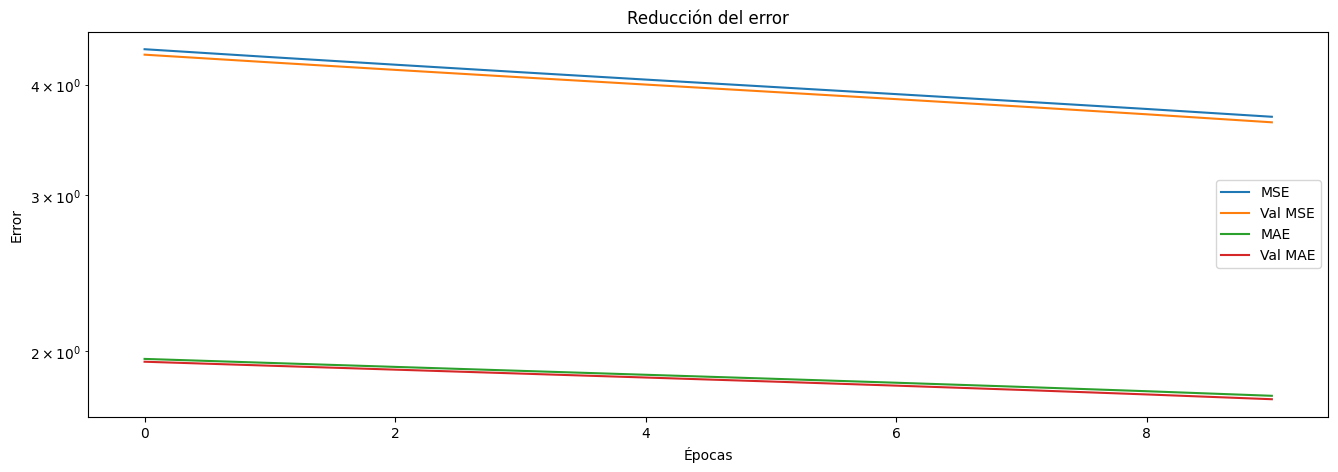

.-------------------------------------------------------------------------------------------------------------------------.
|                                                 Pérdida MLP ruidos bajos                                                |
.---------.---------.---------.---------.---------.---------.---------.---------.---------.---------.----------.----------.
| Errores | Época 1 | Época 2 | Época 3 | Época 4 | Época 5 | Época 6 | Época 7 | Época 8 | Época 9 | Época 10 | Promedio |
.---------.---------.---------.---------.---------.---------.---------.---------.---------.---------.----------.----------.
|   MAE   |  1.960  |  1.939  |  1.919  |  1.900  |  1.880  |  1.861  |  1.842  |  1.822  |  1.802  |  1.780   |  1.871   |
|   MSE   |  4.388  |  4.300  |  4.215  |  4.134  |  4.055  |  3.979  |  3.904  |  3.830  |  3.756  |  3.681   |  4.024   |
|   RMSE  |  2.095  |  2.074  |  2.053  |  2.033  |  2.014  |  1.995  |  1.976  |  1.957  |  1.938  |  1.919   |  2.006   |
.-------

In [ ]:
grafica_loss(history)
perdida(1)

In [ ]:
tiempos()

+-----------------------------------------------+
|              Tiempos de ejecución             |
+---------------------+-------------------------+
|        Modelo       | Tiempo de ejecución [s] |
+---------------------+-------------------------+
|  MLP (ruidos bajos) |          9.252          |
|  MLP (ruidos altos) |          6.445          |
| LSTM (ruidos bajos) |          69.035         |
| LSTM (ruidos altos) |          78.578         |
+---------------------+-------------------------+


In [ ]:
errores(pred1)

+----------------------------------------------+
|            Errores de predicción             |
+------------+----------------+----------------+
| Predicción | Error L1 (MAE) | Error L2 (MSE) |
+------------+----------------+----------------+
| MLP bajos  |    176.186     |    341.905     |
+------------+----------------+----------------+


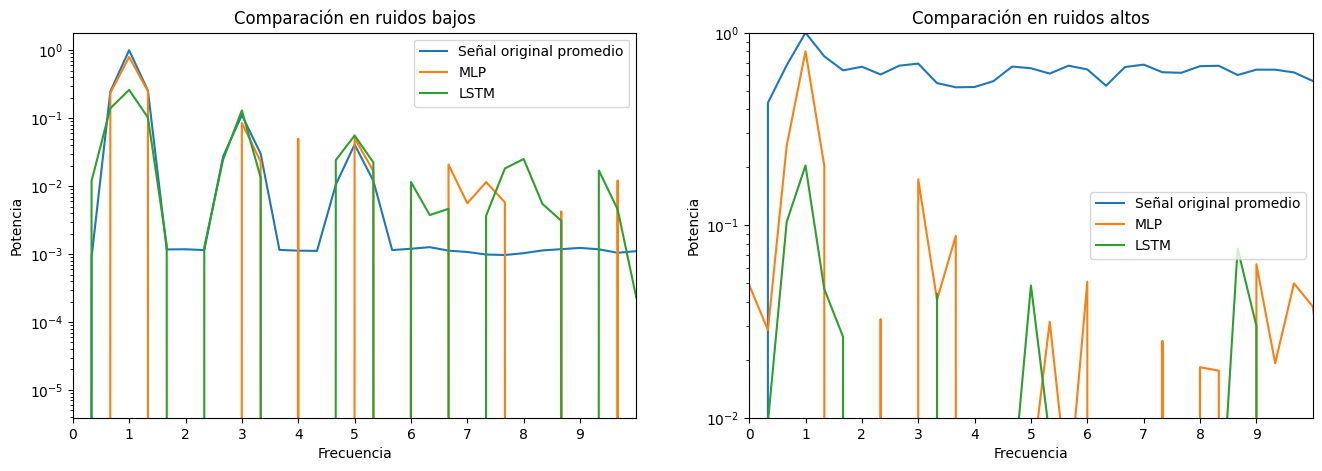

In [ ]:
# grafica(pred1,pred2,pred3,pred4)

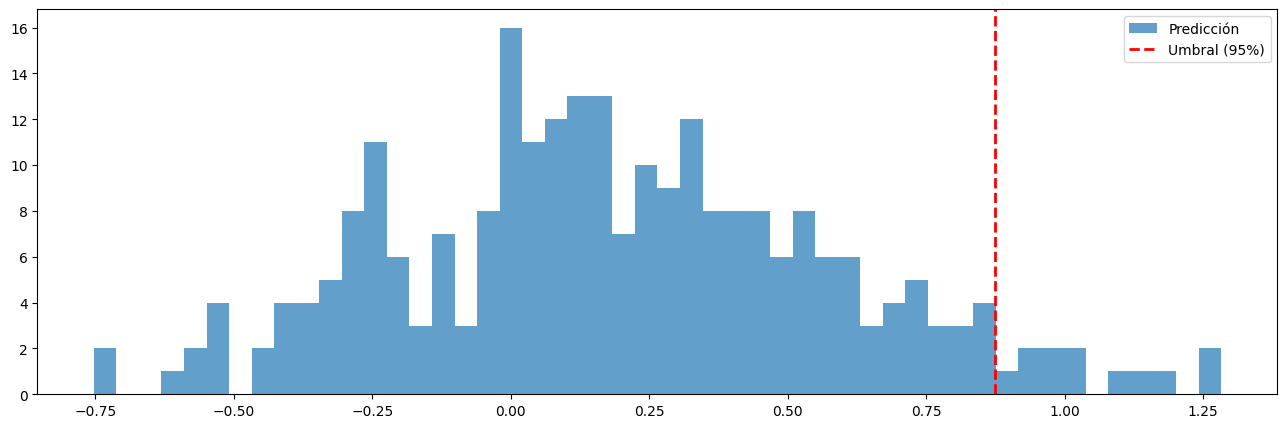

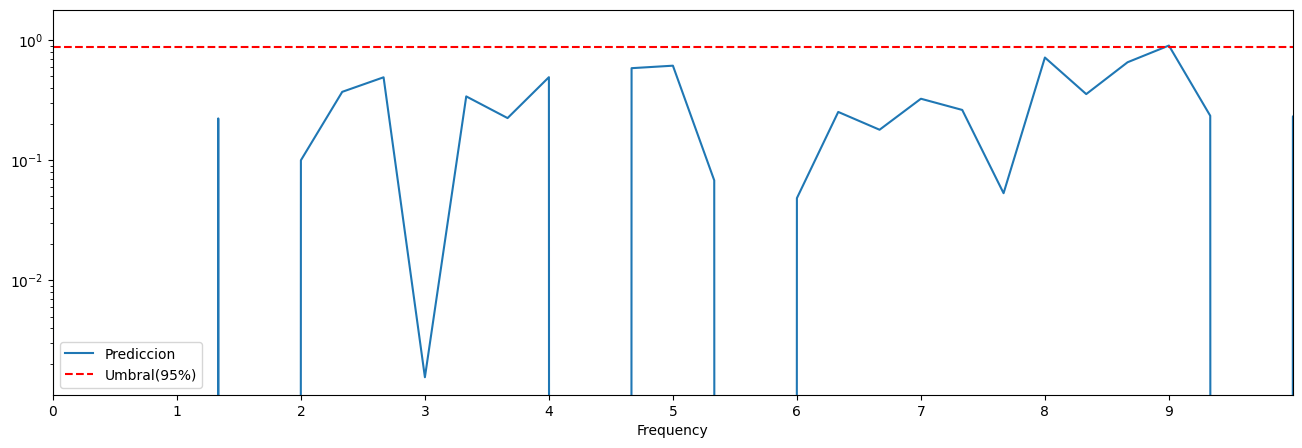

In [ ]:
umbral(95,pred1[10])

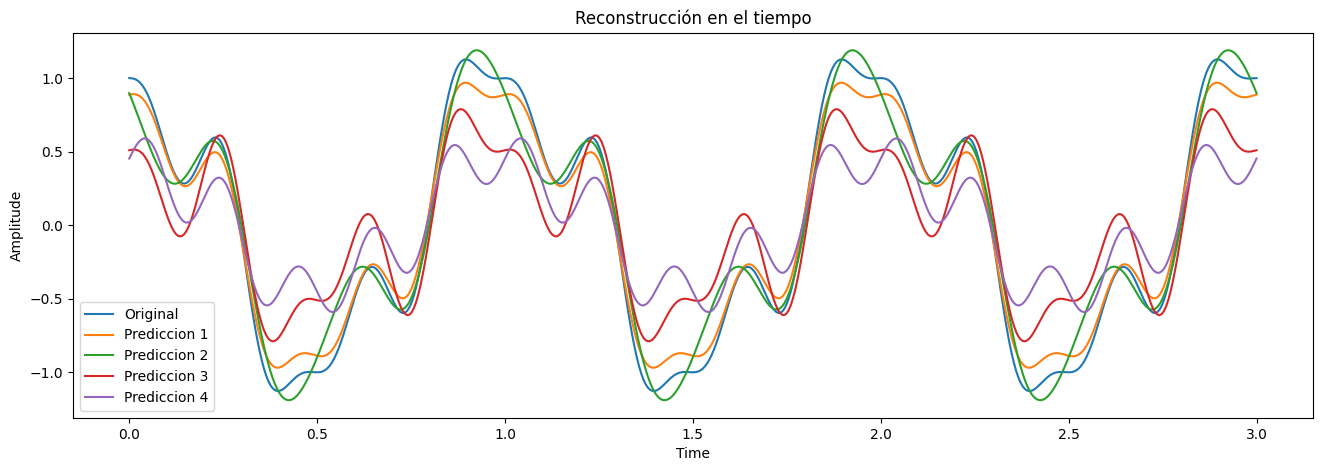

+----------------------------------------------+
|          Errores de reconstrucción           |
+------------+----------------+----------------+
| Predicción | Error L1 (MAE) | Error L2 (MSE) |
+------------+----------------+----------------+
| MLP bajos  |     8.359      |     0.920      |
| MLP altos  |     11.064     |     2.042      |
| LSTM bajos |     31.484     |     12.141     |
| LSTM altos |     37.122     |     18.037     |
+------------+----------------+----------------+


In [ ]:
xr_1,xr_2,xr_3,xr_4 = recons(0,pred1,pred2,pred3,pred4)
errores_recons(xr_1,xr_2,xr_3,xr_4)

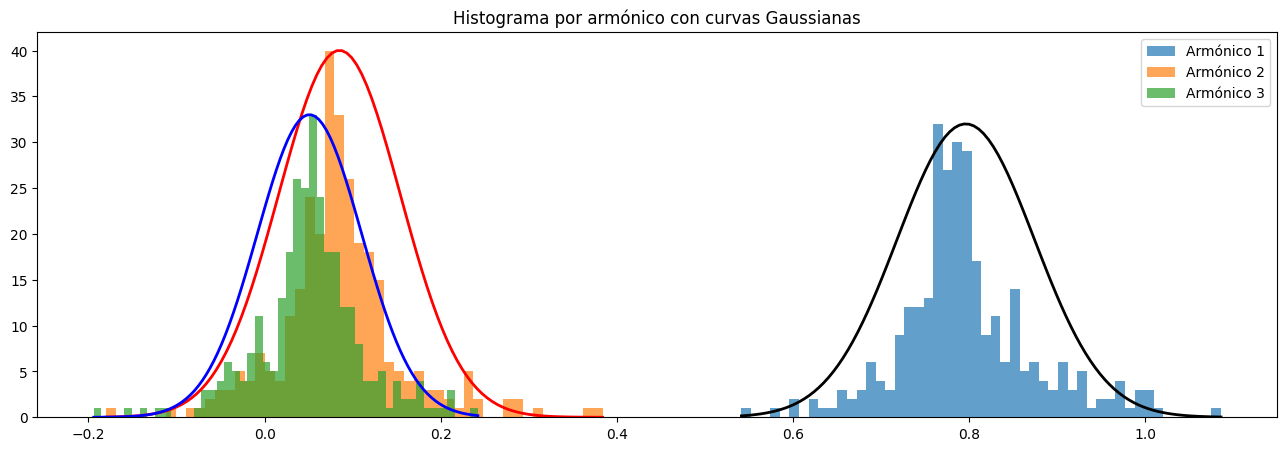

In [ ]:
hist(pred1)